In [137]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import bk.load
import bk.compute
import bk.signal

In [89]:
#delete
path='Z:\\Rat08\\Rat08-20130709'
bk.load.current_session(path)

Rat : 8 on day : 2
Working with session Rat08-20130709 @ Z:\Rat08\Rat08-20130709


True

In [95]:
session_paths=['Z:\\Rat08\\Rat08-20130708',
 'Z:\\Rat08\\Rat08-20130709',
 'Z:\\Rat08\\Rat08-20130710',
 'Z:\\Rat08\\Rat08-20130711',
 'Z:\\Rat08\\Rat08-20130712',
 'Z:\\Rat08\\Rat08-20130713',
 'Z:\\Rat08\\Rat08-20130715',
 'Z:\\Rat08\\Rat08-20130716',
 'Z:\\Rat08\\Rat08-20130717',
 'Z:\\Rat08\\Rat08-20130718',
 'Z:\\Rat08\\Rat08-20130719',
 'Z:\\Rat09\\Rat09-20140324',
 'Z:\\Rat09\\Rat09-20140325',
 'Z:\\Rat09\\Rat09-20140326',
 'Z:\\Rat09\\Rat09-20140327',
 'Z:\\Rat09\\Rat09-20140328',
 'Z:\\Rat09\\Rat09-20140329',
 'Z:\\Rat09\\Rat09-20140331',
 'Z:\\Rat09\\Rat09-20140401',
 'Z:\\Rat09\\Rat09-20140402',
 'Z:\\Rat09\\Rat09-20140403',
 'Z:\\Rat09\\Rat09-20140404',
 'Z:\\Rat09\\Rat09-20140405',
 'Z:\\Rat09\\Rat09-20140407',
 'Z:\\Rat09\\Rat09-20140408',
 'Z:\\Rat09\\Rat09-20140409',
 'Z:\\Rat10\\Rat10-20140619',
 'Z:\\Rat10\\Rat10-20140620',
 'Z:\\Rat10\\Rat10-20140622',
 'Z:\\Rat10\\Rat10-20140624',
 'Z:\\Rat10\\Rat10-20140626',
 'Z:\\Rat10\\Rat10-20140627',
 'Z:\\Rat10\\Rat10-20140628',
 'Z:\\Rat10\\Rat10-20140629',
 'Z:\\Rat10\\Rat10-20140701',
 'Z:\\Rat10\\Rat10-20140702',
 'Z:\\Rat10\\Rat10-20140703',
 'Z:\\Rat10\\Rat10-20140704',
 'Z:\\Rat10\\Rat10-20140705',
 'Z:\\Rat10\\Rat10-20140707',
 'Z:\\Rat10\\Rat10-20140708',
 'Z:\\Rat11\\Rat11-20150310',
 'Z:\\Rat11\\Rat11-20150312',
 'Z:\\Rat11\\Rat11-20150313',
 'Z:\\Rat11\\Rat11-20150314',
 'Z:\\Rat11\\Rat11-20150315',
 'Z:\\Rat11\\Rat11-20150316',
 'Z:\\Rat11\\Rat11-20150317',
 'Z:\\Rat11\\Rat11-20150321',
 'Z:\\Rat11\\Rat11-20150323',
 'Z:\\Rat11\\Rat11-20150325',
 'Z:\\Rat11\\Rat11-20150326',
 'Z:\\Rat11\\Rat11-20150328',
 'Z:\\Rat11\\Rat11-20150330',
 'Z:\\Rat11\\Rat11-20150331',
 'Z:\\Rat11\\Rat11-20150401',
 'Z:\\Rat11\\Rat11-20150402',
 'Z:\\Rat11\\Rat11-20150403']
session_test=session_paths[-10:-1]
session_paths[-1]

'Z:\\Rat11\\Rat11-20150403'

In [20]:
#load data and split neurons in the selected region by type
def split_neurons_types_regions(path, brain_region):
    bk.load.current_session(path)
    neurons, metadata = bk.load.loadSpikeData(path)
    pyramidal = neurons[(metadata['Type']=='Pyr') & (metadata['Region']==brain_region)]
    interneurons = neurons[(metadata['Type']=='Int') & (metadata['Region']==brain_region)]
    other_neurons = neurons[metadata['Type']=='Unk']
    return pyramidal, interneurons, other_neurons

In [22]:
#delete test
h=split_neurons_types_regions(session_paths[0],'BLA')

Rat : 8 on day : 1
Working with session Rat08-20130708 @ Z:\Rat08\Rat08-20130708
Data already saved in Numpy format, loading them from here:
Rat08-20130708-neurons.npy
Rat08-20130708-metadata.npy


In [189]:
def get_firing_rate_for_specific_state(neurons, state):
    """
    Returns a pandas Series object with the mean firing rate of each of the neurons during a chosen state (REM, sws, drowsy, or wake)
    
    Keyword arguments:
    neurons -- numpy.ndarray containing series data of selected neurons 
    state -- string, should be one of the following: Rem, sws, drowsy, wake (default='REM')
    
    Restrictions:
    Can only be called when the neurons and session have already been loaded.
    """
    mean_firing_rates = pd.Series(index = np.arange(len(neurons)),dtype='float64')
    state_used = bk.load.states()[state]

    for i in range(len(neurons)):
        try:
            spk_time = neurons[i].restrict(state_used).as_units('ms').index.values
            mean_firing_rates[i] = len(spk_time)/state_used.tot_length('s')
        except Exception:
            pass #using this exeption because not all neurons have spikes in all states. The nan values cannot be used to calculate firing rates.
#     mean_firing_rates=mean_firing_rates.dropna()
    return mean_firing_rates

In [190]:
get_firing_rate_for_specific_state(neurons, 'wake')

0      3.407788
1      0.191455
2      0.374643
3      0.404388
4           NaN
         ...   
185         NaN
186         NaN
187    5.325195
188         NaN
189    2.072085
Length: 190, dtype: float64

In [131]:
#delete not needed
#firing rate of cells during a given time
def get_firing_rate_for_all_states(neurons):
    
    states= bk.load.states()
    possible_states=list(states.keys())
    mean_firing_rates = pd.DataFrame(index = np.arange(len(neurons)),columns=possible_states, dtype='float64')
    
    for state in possible_states:
        state_used=states[state]
        for i in range(len(neurons)):
            spk_time = neurons[i].restrict(states[state_used]).as_units('ms').index.values
            mean_firing_rates[state][i] = len(spk_time)/state_used.tot_length('s')

    return mean_firing_rates 

In [80]:
# h=get_firing_rate_for_all_states(neurons)
states= bk.load.states()
states_labels=list(states.keys())
mean_firing_rates = pd.DataFrame(index = np.arange(len(neurons)),columns=states_labels, dtype='float64')
for state in states_labels:
    for i in range(len(neurons)):
        spk_time = neurons[i].restrict(states[state]).as_units('ms').index.values
        mean_firing_rates[state][i] = len(spk_time)/states[state].tot_length('s')

0 [ 3685968.5   3687728.7   3687960.4  ... 22991582.05 22991587.8
 22991921.85] 3.577930174563591
1 [ 3699349.05   3699973.7    3700489.85   3718499.9    3725482.95
  3726555.95   3734625.5    3737558.95   3740675.1    3745702.5
  3746826.3    3750798.25   3753966.45   3757946.25   3759788.3
  3775400.35   3782291.9    3784888.65   3788320.35   3797936.8
  3815371.25   3820183.1    3831048.6    3832869.95   4205037.05
  4207163.95   4213883.75   4222795.3    4223862.8    4228260.25
  4235973.5    4242946.799  4639125.2    4649985.1    4656151.2
  4678298.95   4678528.5    4692738.6    4693602.7    4708420.4
  4709601.6    4710693.     4714831.05   4734259.85   4736392.15
  4742229.7    5551068.45   5555071.     5556941.2    5560792.25
  5571002.2    5587814.4    5591726.65   5599699.05   5606032.05
  5628626.15   5644607.45   5648512.7    5649657.2    6807483.55
  6813608.7    7184350.85   7191124.4    7218996.85   7227561.75
  7499328.9    7503527.85   7508901.65   7515053.25   751828

19 [ 3684164.    3684231.6   3684285.65 ... 22991912.8  22991930.75
 22991949.75] 13.96633416458853
20 [ 3688829.2   3689981.05  3689996.5  ... 22990750.1  22991705.15
 22991733.4 ] 1.6365336658354115
21 [ 3684405.4   3684429.25  3684522.45 ... 22990688.8  22990876.1
 22991610.  ] 5.767456359102244
22 [ 3687259.5   3689535.75  3689543.65 ... 22988268.6  22988279.5
 22988856.4 ] 0.9463840399002493
23 [ 3687164.9  3690994.2  3691636.2 ... 22989263.3 22989378.8 22990490.9] 1.06857855361596
24 [ 3694294.8    3704459.     3715229.75   3727033.     3729849.
  3744445.95   3752217.5    3753779.35   3754286.1    3754606.35
  3755595.95   3756472.7    3756641.4    3760857.1    3761743.
  3762822.05   3764480.2    3765470.25   3766320.95   3772080.35
  3779404.85   3779573.45   3781643.25   3791516.9    3796107.4
  3798454.95   3819552.7    3820435.85   3821485.75   3825458.8
  3827570.05   3829820.8    3829934.7    4205572.75   4205587.
  4225381.65   4226376.1    4229439.749  4230295.699  4241

35 [ 3712341.65  3742239.7   3823871.75 ... 22990076.7  22990087.15
 22990156.6 ] 0.7980049875311721
36 [ 3684746.05  3689144.95  3690545.9  ... 22990511.5  22990883.95
 22991722.35] 0.9694513715710723
37 [ 3685548.1    3687784.1    3688982.85   3774871.75   3782799.1
  3809029.35   3814677.55   3829668.4    4232215.     4644825.25
  4644829.35   4647955.15   4652858.3    4655121.3    4660969.15
  4665358.25   4669417.1    4676330.2    4680486.1    4681082.3
  4681086.1    4681525.75   4685875.4    4686402.55   4686568.7
  4687029.45   4687034.7    4695231.9    4697883.9    4701401.35
  4701407.05   4701489.2    4703737.7    4703748.65   4704569.5
  4704573.85   4704603.4    4704705.     4704740.75   4704780.5
  4704851.9    4710269.65   4710330.35   4716738.7    4717574.75
  4718681.5    4722249.2    4724313.35   4724759.45   4724763.85
  4724769.75   4725011.3    4733250.35   4741699.35   4743903.75
  4748201.05   4748816.     4749862.75   4749875.3    4750886.4
  4751454.15   475319

53 [ 3684107.45  3684364.    3684380.7  ... 22989498.25 22989828.55
 22990972.5 ] 1.1695760598503742
54 [ 3690719.05   3695903.15   3709982.3    3737698.2    3738814.65
  3752290.65   3767829.     3788545.     3826729.4    4213035.549
  4219099.1    4220931.2    4230560.999  4234119.05   4241340.199
  4669817.8    4670332.2    4672455.55   4677791.9    4698751.2
  4698789.     4706172.     4715500.4    4737116.5    4745608.8
  4745649.45   4745985.3    4750901.95   4756723.85   5557979.65
  5582084.85   5583703.45   5590451.95   5602816.95   5604644.45
  5619956.8    5620011.55   5620131.2    5628524.55   5645499.3
  5645539.3    5645564.2    5645643.7    5645664.2    5645700.7
  5649830.05   6810474.85   6810523.7    6810535.25   6810542.25
  7185888.35   7190301.35   7190728.65   7198411.6    7209072.75
  7209091.1    7217337.35   7222408.05   7222489.6    7222767.35
  7222980.2    7506393.9    7512035.5    7520782.15   7525092.25
  7525098.4    7525158.5    7525177.     7525297.05  

70 [ 3685030.7   3685240.1   3689685.85 ... 22981264.6  22991829.05
 22991921.95] 0.6751870324189526
71 [ 3693749.9    3740460.6    4645408.65   4645446.5    4649373.
  4650449.9    4650577.4    4650623.2    4650866.35   4650904.25
  4651019.8    4651644.65   4651655.7    4662620.65   4664761.2
  4665095.3    4665123.45   4665131.8    4665159.35   4665206.95
  4665371.05   4665496.35   4665630.95   4665858.3    4667751.05
  4672569.     4672619.9    4672643.4    4673220.4    4673237.85
  4673358.6    4674322.55   4674350.5    4674356.3    4674362.95
  4674384.1    4674969.55   4675035.7    4694827.4    4694862.05
  4694937.6    4695049.75   4695266.45   4695702.7    4695712.25
  4695765.95   4695828.45   4695834.05   4695893.7    4696351.6
  4696810.6    4711110.4    4720887.4    4720903.45   4721175.65
  4721181.1    4721195.1    4721238.65   4721804.9    4721834.6
  4721870.2    4722269.9    4722276.1    4731977.75   4732014.55
  4732062.6    4736007.65   4745262.3    4745293.55   47

88 [ 3825136.85   3825334.2    3825675.45   4654510.2    4654537.3
  4657019.6    4660889.2    4700280.2    4710968.45   4741595.15
  4741600.1    4741639.2    4741656.85   4749117.9    4753759.75
  5550512.75   5579939.85   5589123.6    5589128.25   5596686.65
  5599955.05   5599960.75   5603342.5    5617113.65   5617124.45
  5618944.35   5619646.3    5622664.25   5622672.     5627690.8
  5628429.55   5634948.65   5634954.75   6805893.5    7197265.3
  7197318.6    7199751.95   7202971.5    7207188.4    7517909.55
  7534491.85   7534519.8    7537966.9    7541439.35   7564330.75
  7567592.45   7572468.55   7892021.05   7892064.25   7892080.
  7901602.6    7906720.6    7928467.35   7929782.75   7929962.35
  7932123.     7935717.15   7939534.7    7943900.45   7956535.45
  7990159.95   8607843.05   8713958.9    8723379.1    8805924.
  8805956.45   8806111.55   8806387.3    8806675.45   8806779.7
  8806893.6    8806950.95   8807177.55   8807451.3    8807673.9
  8807804.05   8808048.     880

105 [ 3685542.85  3685603.1   3685749.9  ... 22984948.1  22984954.4
 22984978.35] 1.3584788029925188
106 [ 3689825.25  3692742.15  3694139.85 ... 22980409.45 22985041.3
 22991038.1 ] 0.6315461346633416
107 [ 3684657.     3685619.45   3689688.8    3689694.3    3690936.8
  3690942.6    3691213.65   3691523.8    3691685.8    3691694.6
  3700226.     3700234.3    3716673.5    3731090.25   3731098.15
  3740346.15   3740352.1    3741036.3    3751305.1    3751430.65
  3752914.7    3753309.4    3765602.15   3766635.45   3766649.5
  3766769.75   3766775.1    3771724.15   3786950.3    3792321.65
  3797185.3    3808495.     3808500.85   3813721.05   3814153.65
  3814158.7    3814165.1    3819610.45   3831108.6    3831686.
  3831696.1    3838249.9    3838257.45   3838269.55   4203618.7
  4210421.     4217747.65   4217757.55   4226995.05   4229165.549
  4229171.9    4234600.9    4236553.5    4237185.749  4240347.45
  4240353.8    4240362.     4243885.1    4243946.65   4638334.05
  4638340.6    4648

124 [ 3695435.9    3697944.55   3702566.9    3707449.3    3709325.85
  3721811.     3737946.1    3747888.45   3750364.65   3750409.
  3750453.6    3766904.35   3767493.3    3768573.45   3785308.9
  3785694.85   3789261.05   3791251.6    3791272.1    3802730.5
  3803884.3    3804038.7    3809043.5    3809552.     3813927.7
  3815342.1    3822269.65   3822282.75   3822310.6    3827402.25
  3827965.6    3837987.05   4203583.55   4205317.     4214879.7
  4215392.05   4226661.85   4238030.899  4638574.45   4656708.4
  4659938.5    4661932.85   4687731.95   4700550.1    4700566.2
  4700822.45   4701045.4    4701059.25   4701097.35   4708346.1
  4711769.5    4722158.85   4725413.9    4733441.25   4741101.25
  4742638.95   4742652.35   4743081.3    4744448.25   4746185.9
  4746456.2    5553415.15   5576100.35   5584927.9    5584951.15
  5611434.7    5611494.1    5611519.55   5611532.9    5615058.6
  5619595.3    5619621.85   5624894.25   5624941.05   5628667.7
  5628901.1    5637639.25   56383

142 [ 3776033.4    3776606.6    3776610.6    3776616.4    3836002.3
  4216502.2    4647580.75   4649049.15   4652460.1    4652520.95
  4652529.45   4653178.45   4656725.5    4657077.7    4658957.
  4663801.85   4664107.     4664144.95   4664175.9    4668464.35
  4670071.35   4676416.05   4676527.3    4677474.9    4678687.75
  4679525.8    4679535.95   4679547.4    4679565.45   4679658.65
  4681177.9    4682714.6    4683407.3    4683486.35   4683492.
  4683532.25   4683556.85   4683602.1    4683610.35   4683628.7
  4683663.25   4683761.45   4683773.15   4683787.25   4683828.25
  4687551.65   4694569.3    4695327.4    4695598.55   4696001.7
  4703620.5    4703875.6    4705514.4    4705624.65   4707826.4
  4709521.5    4709681.9    4709688.15   4709701.35   4709704.6
  4709733.45   4715513.2    4715546.2    4719322.55   4719549.5
  4721503.5    4721509.85   4721528.05   4722602.8    4724230.05
  4729361.7    4729367.2    4732030.9    4733687.5    4734202.45
  4734622.8    4734647.65   473

159 [ 3694452.05   3703647.65   3716700.6    3735613.75   3737766.45
  3741013.75   3741361.6    3749697.8    3812375.3    4209889.849
  4214821.149  4216799.2    4217196.7    4217440.95   4217455.
  4220244.399  4221554.9    4225457.     4227310.8    4227892.799
  4237842.649  4238199.1    4243125.699  4643830.4    4644652.3
  4648700.8    4665987.05   4668448.35   4672982.25   4676136.4
  4676247.85   4679909.5    4681692.05   4681872.45   4688762.3
  4696827.2    4712492.05   4712678.6    4713875.3    4722589.6
  4722602.85   4722618.65   4724719.25   4727325.25   4727335.7
  4731414.35   4731422.9    4731441.65   4732496.7    4734799.85
  4735878.35   4737341.65   4740255.95   4743700.65   4747040.2
  4747080.35   4747091.7    4747207.25   4750648.35   4750675.45
  4751426.1    4751641.55   4756613.     5563732.8    5570808.95
  5571020.35   5574653.6    5575290.4    5575435.2    5580014.35
  5588134.8    5588255.3    5588305.95   5600196.95   5600302.5
  5602809.25   5616055.1    

172 [ 3684372.65   3684523.15   3690189.6    3691521.75   3691529.9
  3691543.65   3691553.3    3691756.55   3704288.     3709922.9
  3718743.75   3733676.85   3757499.3    3775416.15   3777907.85
  3779630.25   3783611.85   3815804.5    3815832.1    3816462.6
  3825007.45   4232245.4    4234881.9    4650949.5    4652070.1
  4652273.45   4652915.4    4653012.5    4654745.55   4656489.8
  4661446.4    4662807.85   4667612.3    4668065.9    4669113.05
  4669119.35   4669132.45   4673682.9    4674974.2    4678035.95
  4678890.3    4679210.2    4681633.3    4691849.5    4694036.2
  4694045.85   4695234.85   4704922.2    4705493.05   4705978.75
  4712745.75   4713485.1    4713991.95   4723012.45   4723530.65
  4723711.9    4724097.45   4725211.8    4725216.75   4725989.95
  4725999.     4732731.75   4745049.2    4747980.55   4749873.3
  4749879.75   5590766.85   5590950.95   5591199.6    5594355.75
  5600628.     5600830.     5601345.25   5602872.05   5603114.15
  5604337.25   5610017.9    

188 [ 3738248.     3741792.8    3807947.     4641602.9    4643037.8
  4643320.7    4644193.35   4644218.7    4644310.9    4644528.3
  4644827.2    4644888.65   4653266.15   4656297.65   4657253.6
  4668291.3    4680691.2    4681510.15   4683142.1    4687514.35
  4698854.2    4698894.6    4699848.55   4699930.7    4700256.3
  4700304.7    4700394.3    4701394.25   4701492.     4701663.4
  4704224.9    4704749.9    4708741.45   4710084.75   4714474.55
  4714629.15   4721221.8    4733542.2    4733642.7    4733982.1
  4736491.6    4744830.65   4744840.4    4744851.3    4744978.85
  4744991.25   4745059.85   4745137.3    4748934.45   4748949.7
  4749997.65   4750819.     4753437.65   4753623.2    4753684.25
  5550598.5    5559678.05   5581973.55   5585649.3    5585666.6
  5594621.4    5595259.15   5597328.3    5603791.4    5604398.35
  5604613.75   5605051.45   5610601.5    5614914.6    5618078.5
  5618151.15   5618170.     5618275.25   5626773.3    5630706.
  5635925.2    5636035.5    6815

38 [ 3025058.25  3025142.4   3027930.6  ... 23425528.45 23426395.15
 23427937.65] 1.2651612903225806
39 [ 3052507.7   3053244.95  3109436.   ... 23421212.65 23421665.7
 23422028.55] 0.5583870967741935
40 [ 3029562.15  3031678.5   3034802.65 ... 23412739.2  23418715.75
 23427706.3 ] 0.6552688172043011
41 [ 3022597.1   3022924.65  3023890.85 ... 23427721.45 23427757.05
 23427962.1 ] 2.4711827956989247
42 [ 3028509.7   3028591.5   3028664.85 ... 23426895.55 23427002.85
 23427842.2 ] 1.4131182795698924
43 [ 3024862.3   3025213.45  3025774.75 ... 23425110.65 23425681.8
 23426112.45] 0.6109677419354839
44 [ 3026134.3   3026194.2   3026458.6  ... 23388233.9  23395970.65
 23417382.35] 0.5138709677419355
45 [ 3022152.15  3023070.15  3024311.7  ... 23416237.2  23418365.8
 23420320.65] 0.8367741935483871
46 [ 3022840.4   3022873.8   3022929.1  ... 23420240.85 23425299.05
 23427388.95] 0.29913978494623655
47 [ 3028268.85  3030514.95  3054460.2  ... 23384322.05 23393731.9
 23417002.2 ] 0.1562365591

59 [ 3024710.55  3033356.95  3038854.15 ... 23378011.4  23386800.
 23387912.15] 0.20118279569892472
60 [ 3022392.95  3022677.25  3023491.35 ... 23335425.85 23389052.
 23420504.65] 0.1389247311827957
61 [ 3028092.7   3028335.25  3038714.95 ... 23278710.55 23287695.95
 23421984.2 ] 0.14376344086021506
62 [ 3022390.65  3036941.25  3036953.05 ... 23398114.25 23422561.5
 23423446.1 ] 0.20236559139784946
63 [ 3022817.4   3038067.7   3042352.45 ... 23417868.25 23418233.55
 23425985.05] 0.2824731182795699
64 [ 3027482.4   3029938.4   3051252.3  ... 23285344.5  23287392.5
 23291763.25] 0.24397849462365592
65 [ 3024880.35  3026640.    3026686.85 ... 23286724.2  23293311.45
 23359056.15] 0.1827956989247312
66 [ 3026755.4   3034131.2   3044156.15 ... 23286433.3  23287504.95
 23415215.15] 0.1664516129032258
67 [ 3022997.4    3023880.2    3122728.15   3126222.15   3144140.9
  3158495.4    3204206.5    3213410.65   3284882.3    3286827.75
  3286844.9    3286850.9    3292534.     3292548.3    3322977.

76 [ 3065255.5    3066473.35   3066545.     3068629.55   3106260.
  3167822.85   3193078.7    3214049.2    3214066.1    3214102.9
  3236032.65   3401570.25   3515884.4    3535698.7    3585167.7
  3585170.55   3900746.05   3990869.35   4007725.8    4110715.8
  4130004.75   4130121.9    4142247.349  4149673.35   4183542.6
  4183579.45   4193308.85   4292738.999  4297096.5    4297280.65
  4364376.9    4411589.5    4424736.35   4424957.45   4442604.5
  4449364.2    4456970.35   4469443.05   4469511.85   4469529.8
  4494760.2    4496828.1    4557701.1    4582756.     4594259.8
  5021749.7    5028614.1    5028629.6    5037983.65   5039226.6
  5044034.8    5101289.3    5101926.55   5158279.65   5160211.6
  5163724.65   5163758.3    5198500.25   5202046.45   5214895.35
  5247269.35   5247340.4    5248740.4    5249097.     5251637.75
  5251673.3    5251740.25   5278854.85   5278901.6    5313690.5
  5329971.7    5355128.15   5386352.3    5391060.85   5410563.
  5425957.35   5426508.45   5427615.

93 [ 3055817.15  3070642.05  3074570.6  ... 23370247.9  23426252.7
 23426914.4 ] 0.17333333333333334
94 [ 3028305.95  3031153.75  3031954.2  ... 23419603.6  23427717.95
 23427728.45] 0.4172043010752688
95 [ 3022840.2   3022976.7   3036709.   ... 23423119.6  23423161.65
 23423167.35] 0.6775268817204301
96 [ 3024241.05  3027500.45  3029886.3  ... 23420317.85 23422512.8
 23427707.75] 0.4603225806451613
97 [ 3022353.25  3023918.9   3025466.9  ... 23419477.3  23422613.1
 23426281.5 ] 0.5309677419354839
98 [ 3022076.6   3024048.45  3024053.7  ... 23426329.75 23426591.2
 23427111.15] 0.3606451612903226
99 [ 3022416.65  3022556.8   3022576.15 ... 23420095.9  23420495.65
 23423807.65] 0.5380645161290323
100 [ 3024993.95  3025001.85  3025016.4  ... 23395637.45 23404944.55
 23404958.25] 0.21763440860215053
101 [ 3022591.8   3026771.85  3026778.2  ... 23330284.3  23330292.
 23353157.65] 0.12344086021505377
102 [ 3024892.4   3025473.45  3025482.95 ... 23421916.95 23422838.05
 23423891.9 ] 0.8748387

154 [ 3024296.9   3025369.45  3025462.5  ... 23416864.   23417398.85
 23421862.65] 0.8463440860215053
155 [ 3022896.6   3023026.05  3023144.3  ... 23426854.4  23427012.
 23427082.85] 3.174301075268817
156 [ 3022044.2   3022122.75  3022160.6  ... 23427829.35 23427830.95
 23427852.85] 6.597096774193548
157 [ 3028509.85  3029004.9   3031402.1  ... 23423057.8  23426045.15
 23426687.2 ] 0.5586021505376344
158 [ 3022216.5   3040430.2   3054148.3  ... 23414787.4  23415001.75
 23415177.6 ] 0.13634408602150538
159 [ 3022379.    3038407.2   3038417.6  ... 23399226.85 23399251.8
 23399261.05] 0.17387096774193547
160 [ 3026651.8   3026902.7   3026960.75 ... 23420216.65 23420562.6
 23425915.7 ] 0.19462365591397848
161 [ 3023473.85  3028283.35  3045899.2  ... 23285795.25 23340744.95
 23401906.55] 0.2046236559139785
162 [ 3022119.95  3022212.5   3022327.2  ... 23427831.   23427910.15
 23427962.3 ] 5.157849462365592
163 [ 3022053.9   3022058.3   3022141.75 ... 23427897.   23427938.3
 23427971.7 ] 26.6

ValueError: cannot convert float NaN to integer

In [81]:
def get_FR_per_state_neurontype(path, states, brain_region):
    '''
    Returns 2 lists (one for each state) with the mean firing rate of each of the types of neurons (Pyramidal, interneurons, unknown) during the chosen state.
    
    Keyword arguments:
    path -- string containing the dircetory where the data files are stored
    states -- list of 2 strings, should be one of the following: REM, sws, drowsy, wake (default='REM')
    '''
    neurons_by_type=split_neurons_types_regions(path, brain_region)
    firing_rates_state0=[]
    firing_rates_state1=[]
    for i in neurons_by_type:
        x=get_firing_rate_for_specific_state(i, states[0])
        y=get_firing_rate_for_specific_state(i, states[1])
        firing_rates_state0.append(x)
        firing_rates_state1.append(y)
    return firing_rates_state0, firing_rates_state1

In [186]:
#test delete
h,g=get_FR_per_state_neurontype(path, ['Rem','wake'],'BLA')

Rat : 8 on day : 2
Working with session Rat08-20130709 @ Z:\Rat08\Rat08-20130709
Data already saved in Numpy format, loading them from here:
Rat08-20130709-neurons.npy
Rat08-20130709-metadata.npy


In [87]:
def get_plot_c_all_sessions(paths, states, brain_region):
    '''
    Returns N lists (one for each state) with the mean firing rate of each of the types of neurons (Pyramidal, interneurons, unknown) during the chosen state
    where N is the number of sessions.
    Returned lists structure = Number of sessions * number of types of cells(=3) * number of cells(depends on session)
    
    Keyword arguments:
    paths -- list of strings containing the dircetories where the data files for each sessions are stored
    states -- list of 2 strings, should be one of the following: REM, sws, drowsy, wake (default='REM')
    '''
    
    all_sessions_state0=[]
    all_sessions_state1=[]

    for path in paths:
        FR_per_cell_state0,FR_per_cell_state1=get_FR_per_state_neurontype(path, states, brain_region)
        all_sessions_state0.append(FR_per_cell_state0)
        all_sessions_state1.append(FR_per_cell_state1)
    return all_sessions_state0, all_sessions_state1

In [187]:
#delete
x,y=get_plot_c_all_sessions(session_paths[12:14], ['Rem','wake'],'BLA')

Rat : 9 on day : 2
Working with session Rat09-20140325 @ Z:\Rat09\Rat09-20140325
Data already saved in Numpy format, loading them from here:
Rat09-20140325-neurons.npy
Rat09-20140325-metadata.npy
Rat : 9 on day : 3
Working with session Rat09-20140326 @ Z:\Rat09\Rat09-20140326
Data already saved in Numpy format, loading them from here:
Rat09-20140326-neurons.npy
Rat09-20140326-metadata.npy


In [108]:
def get_scatter_plot(paths, states, brain_region):
    x,y=get_plot_c_all_sessions(paths, states, brain_region)
    identity=np.linspace(-10,100,101) 
    plt.plot(identity,identity, 'k-', color='b')
    for i in range(len(x)):
        plt.scatter(x[i][2],y[i][2], color='gray')
        plt.scatter(x[i][0],y[i][0], color='r')
        plt.scatter(x[i][1],y[i][1], color='b')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel(f'{states[0]} rate (Hz)')
    plt.ylabel(f'{states[1]} rate (Hz)')

Rat : 8 on day : 1
Working with session Rat08-20130708 @ Z:\Rat08\Rat08-20130708
Data already saved in Numpy format, loading them from here:
Rat08-20130708-neurons.npy
Rat08-20130708-metadata.npy
Rat : 8 on day : 2
Working with session Rat08-20130709 @ Z:\Rat08\Rat08-20130709
Data already saved in Numpy format, loading them from here:
Rat08-20130709-neurons.npy
Rat08-20130709-metadata.npy
Rat : 8 on day : 3
Working with session Rat08-20130710 @ Z:\Rat08\Rat08-20130710
Data already saved in Numpy format, loading them from here:
Rat08-20130710-neurons.npy
Rat08-20130710-metadata.npy
Rat : 8 on day : 4
Working with session Rat08-20130711 @ Z:\Rat08\Rat08-20130711
Data already saved in Numpy format, loading them from here:
Rat08-20130711-neurons.npy
Rat08-20130711-metadata.npy
Rat : 8 on day : 5
Working with session Rat08-20130712 @ Z:\Rat08\Rat08-20130712
Data already saved in Numpy format, loading them from here:
Rat08-20130712-neurons.npy
Rat08-20130712-metadata.npy
Rat : 8 on day : 6
W

Rat11-20150310-metadata.npy
Rat : 11 on day : 3
Working with session Rat11-20150312 @ Z:\Rat11\Rat11-20150312
Data already saved in Numpy format, loading them from here:
Rat11-20150312-neurons.npy
Rat11-20150312-metadata.npy
Rat : 11 on day : 4
Working with session Rat11-20150313 @ Z:\Rat11\Rat11-20150313
Data already saved in Numpy format, loading them from here:
Rat11-20150313-neurons.npy
Rat11-20150313-metadata.npy
Rat : 11 on day : 5
Working with session Rat11-20150314 @ Z:\Rat11\Rat11-20150314
Data already saved in Numpy format, loading them from here:
Rat11-20150314-neurons.npy
Rat11-20150314-metadata.npy
Rat : 11 on day : 6
Working with session Rat11-20150315 @ Z:\Rat11\Rat11-20150315
Data already saved in Numpy format, loading them from here:
Rat11-20150315-neurons.npy
Rat11-20150315-metadata.npy
Rat : 11 on day : 7
Working with session Rat11-20150316 @ Z:\Rat11\Rat11-20150316
Data already saved in Numpy format, loading them from here:
Rat11-20150316-neurons.npy
Rat11-20150316-

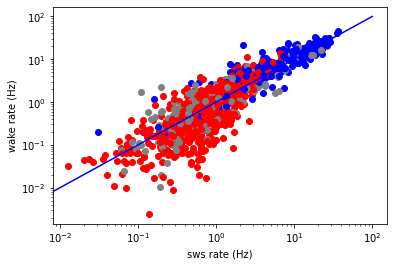

In [193]:
h=get_scatter_plot(session_paths, ['sws','wake'], 'BLA')